In [1]:
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import random
import pandas as pd
import logging
from tqdm import tqdm
import time

In [2]:
title = "Software Developer"  
location = "Linköping"  
NUMBER_OF_JOBS_TO_FETCH = 600
SAVE_DATA = True

In [3]:
from collections import defaultdict
programming_languages = pd.read_csv('./skills.csv')['skills'].to_list()
programming_languages = set(programming_languages)

users_of_languages = defaultdict(int)
for l in programming_languages:
    users_of_languages[l] = 0

In [4]:
job_list = []

In [5]:
for start in tqdm(range(0, NUMBER_OF_JOBS_TO_FETCH, 25)):
    list_url = f"https://www.linkedin.com/jobs-guest/jobs/api/seeMoreJobPostings/search?keywords={title}&location={location}&distance=25&f_TPR=&f_WT=1&start={start}"

    response = requests.get(list_url)

    list_data = response.text
    list_soup = BeautifulSoup(list_data, "html.parser")
    page_jobs = list_soup.find_all("li")
        
    id_list = []

    for job in page_jobs:
        base_card_div = job.find("div", {"class": "base-card"})
        job_id = base_card_div.get("data-entity-urn").split(":")[3]
        id_list.append(job_id)
    
    for job_id in id_list:
        job_url = f"https://www.linkedin.com/jobs-guest/jobs/api/jobPosting/{job_id}"
        
        job_response = requests.get(job_url)
        if job_response.status_code != 200:
            logging.warning(f"Failed to retrieve job posting {job_id}: Status code {job_response.status_code}")
            continue
        job_soup = BeautifulSoup(job_response.text, "html.parser")
        
        job_post = {}
        
        try:
            job_post["job_title"] = job_soup.find("h2", {"class":"top-card-layout__title font-sans text-lg papabear:text-xl font-bold leading-open text-color-text mb-0 topcard__title"}).text.strip()
        except:
            job_post["job_title"] = None
            
        try:
            job_post["company_name"] = job_soup.find("a", {"class": "topcard__org-name-link topcard__flavor--black-link"}).text.strip()
        except:
            job_post["company_name"] = None

        try: 
            job_post["location"] = job_soup.find("span", {"class": "topcard__flavor topcard__flavor--bullet"}).text.strip().split(",")[0].strip()
        except:
            job_post["location"] = None
            
        try:
            job_post["time_posted"] = job_soup.find("span", {"class": "posted-time-ago__text topcard__flavor--metadata"}).text.strip()
        except:
            job_post["time_posted"] = None
            
        try:
            job_post["num_applicants"] = job_soup.find("span", {"class": "num-applicants__caption topcard__flavor--metadata topcard__flavor--bullet"}).text.strip().replace(" applicants", "")
        except:
            job_post["num_applicants"] = 0 

        for lang in programming_languages:
            if f"{lang.lower()}" in job_soup.find("div", {"class": "show-more-less-html__markup show-more-less-html__markup--clamp-after-5 relative overflow-hidden"}).text.lower():  
                users_of_languages[lang] += 1 
        job_list.append(job_post)
        time.sleep(random.uniform(1, 3))  

100%|██████████| 24/24 [01:48<00:00,  4.50s/it]


## Job postings 

In [6]:
jobs_df = pd.DataFrame(job_list)
print(f"Total job postings collected: {len(jobs_df)}")
jobs_df.head(15)

Total job postings collected: 40


,job_title,company_name,location,time_posted,num_applicants
0,Algoritmutveckling / Reglerteknik / Modellbase...,Combine,Linköping,2 weeks ago,0
1,Software Engineer,Medius,Linköping,2 months ago,0
2,System developer to Linköping!,TMC Sweden,Linköping,6 days ago,26
3,Testare inom mjukvara,Professional Galaxy AB,Linköping,8 months ago,39
4,"Software Developer, Backend - Sectra Medical",Sectra,Linköping,2 weeks ago,192
5,Software Engineer,Voyado,Norrköping,6 days ago,29
6,Utvecklare Java,Nexer Group,Linköping,2 days ago,0
7,Software Developer,Väderstad AB,Linköping,2 weeks ago,32
8,Java Software Engineer,Piktiv AB,Linköping,1 week ago,34
9,Erfaren .Net-utvecklare,XLENT,Norrköping,1 month ago,0


In [7]:
if SAVE_DATA:
    jobs_df.to_csv(f'./results/jobs_{title}_{location}.csv', index=False)

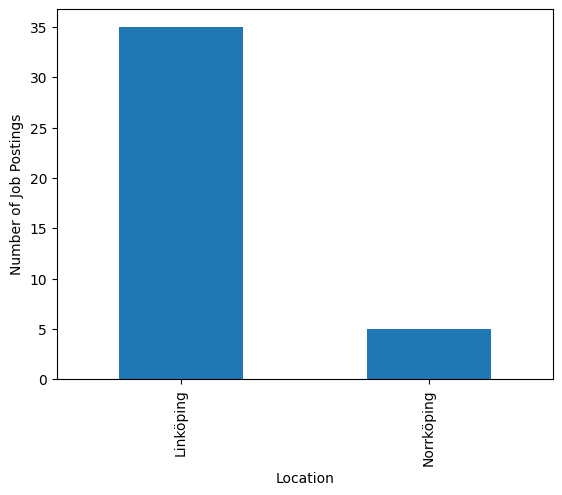

In [8]:
jobs_df["location"].value_counts().plot(kind='bar')
plt.xlabel('Location')
plt.ylabel('Number of Job Postings')
plt.savefig(f'./results/job_locations_{title}_{location}.png')
plt.show()

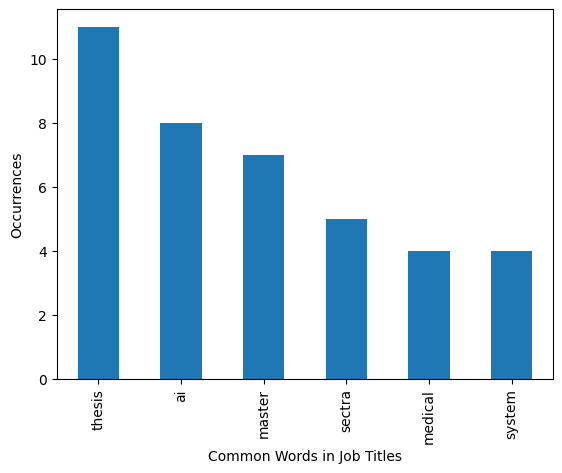

In [9]:
jobs_df['job_title_cleaned'] = jobs_df['job_title'].str.replace(r'[\/\-\,\(\)\.]', ' ', regex=True)
all_words = ' '.join(jobs_df['job_title_cleaned'].dropna().tolist()).lower().split()
word_counts = pd.Series(all_words).value_counts()
common_words = word_counts[word_counts > 2]
common_words.plot(kind='bar')
common_words = common_words.drop(errors="ignore", labels=['developer', "utvecklare", "mjukvaruutvecklare", 'engineer', 'software', 'and', 'lead', "iii" 'ii', 'i', 'working', 'from', 'home', 'm/f/d', 'h/f', 'the', 'a', 'to', 'in', 'of', 'for', 'with', 'on', 'at', 'as', 'is', 'by', 'an', "inom", "för", "all"])
common_words.plot(kind='bar')
plt.xlabel('Common Words in Job Titles')
plt.ylabel('Occurrences')
plt.savefig(f'./results/common_words_job_titles_{title}_{location}.png')
plt.show()

## Skills usage in job postings 

In [10]:
lang_usage = pd.DataFrame.from_dict(users_of_languages, orient='index', columns=['Number of Job Postings']).reset_index().rename(columns={'index': 'Programming Language'})
lang_usage.drop(lang_usage[lang_usage['Number of Job Postings'] == 0].index, inplace=True)
lang_usage = lang_usage.sort_values(by='Number of Job Postings', ascending=False)
lang_usage = lang_usage.reset_index(drop=True)
lang_usage.head(20)

,Programming Language,Number of Job Postings
0,C++,12
1,Git,11
2,Python,11
3,Azure,11
4,C#,10
5,Java,7
6,Kubernetes,7
7,iOS,6
8,DevOps,6
9,Docker,6


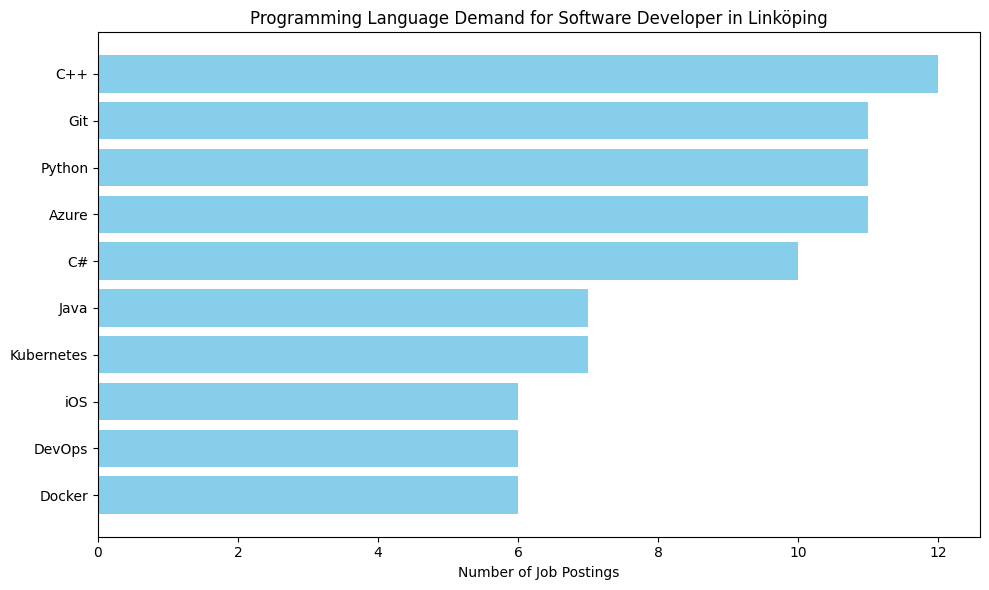

In [11]:
plt.figure(figsize=(10, 6))
plt.barh(lang_usage['Programming Language'].iloc[:10], lang_usage['Number of Job Postings'].iloc[:10], color='skyblue')
plt.xlabel('Number of Job Postings')
plt.title(f'Programming Language Demand for {title} in {location}')
plt.gca().invert_yaxis() 
plt.tight_layout()
plt.savefig(f'./results/language_demand_{title}_{location}.png')
plt.show()

In [12]:
if SAVE_DATA:
    lang_usage.to_csv(f'./results/skills_{title}_{location}.csv', index=False)